# Imports

In [135]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm


import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data.dataset import Subset

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torchvision.models.vgg import vgg16
import matplotlib.pyplot as plt
from torchinfo import summary

print(torch.__version__)
print(torchvision.__version__)

2.1.2
0.16.2


In [2]:
def create_folder(path):
    if not os.path.exists(path):
        os.makedirs(path)

# Problem 1



## Dataset & Dataloader

In [13]:
transform = transforms.Compose([
  transforms.RandomCrop(32, padding=4),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize(
      (0.4914, 0.4822, 0.4465),
      (0.2023, 0.1994, 0.2010))])

batch_size = 1024

START_PATH = "data/"
create_folder(f"{START_PATH}/CIFAR10/")

train_data = CIFAR10(root=f"{START_PATH}/CIFAR10/train/",
                    train=True, 
                    download=True,
                    transform=transform)

print(train_data)
print(f"    len:{len(train_data)}")
print(f"    shape:{train_data.data.shape[1:]}")
print(f"    classes:{train_data.class_to_idx}")

trainset, valset = random_split(
                      train_data, 
                      [40000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False)

testset = CIFAR10(root=f"{START_PATH}/CIFAR10/test/", 
                    train=False, 
                    download=True,
                    transform=transform)
print(testset)
print(f"    len:{len(testset)}")
print(f"    shape:{testset.data.shape[1:]}")
print(f"    classes:{testset.class_to_idx}")

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data//CIFAR10/train/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
    len:50000
    shape:(32, 32, 3)
    classes:{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data//CIFAR10/test/
    Split: Test
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
    len:10000
    shape:(

Files already downloaded and verified
Files already downloaded and verified


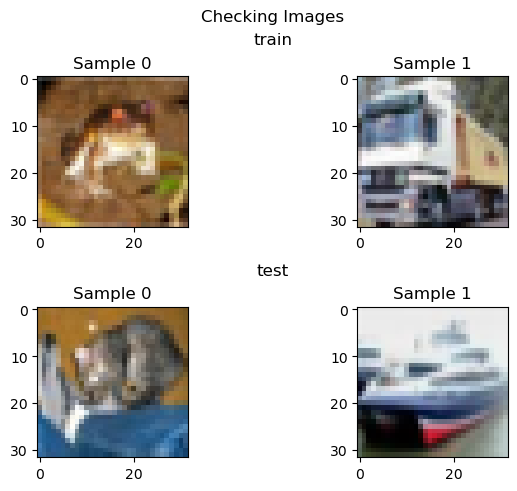

In [30]:
fig = plt.figure(constrained_layout=True)
fig.suptitle('Checking Images')

A = CIFAR10(root=f"{START_PATH}/CIFAR10/train/",
                    train=True, 
                    download=True,)
B = CIFAR10(root=f"{START_PATH}/CIFAR10/test/", 
                    train=False, 
                    download=True,)

subfigs = fig.subfigures(nrows=2, ncols=1)
for row, subfig in enumerate(subfigs):
    dataset = B if row else A
    subfig.suptitle(f'{"test" if row else "train"}')
    axs = subfig.subplots(nrows=1, ncols=2)
    for col, ax in enumerate(axs):
        ax.imshow(dataset[col][0])
        ax.set_title(f'Sample {col}')

## Model

In [52]:
model = vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)
device = "cuda:1" if torch.cuda.is_available() else "cpu"
model = model.to(device=device)
print(summary(model, input_size=(1, 3, 224, 224)))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

In [53]:
model.classifier[-1] = nn.Linear(4096, 10)
device = "cuda:1" if torch.cuda.is_available() else "cpu"
model = model.to(device=device)

summary(model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 512, 1, 1]            --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           1,792
│    └─ReLU: 2-2                         [1, 64, 32, 32]           --
│    └─Conv2d: 2-3                       [1, 64, 32, 32]           36,928
│    └─ReLU: 2-4                         [1, 64, 32, 32]           --
│    └─MaxPool2d: 2-5                    [1, 64, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 128, 16, 16]          73,856
│    └─ReLU: 2-7                         [1, 128, 16, 16]          --
│    └─Conv2d: 2-8                       [1, 128, 16, 16]          147,584
│    └─ReLU: 2-9                         [1, 128, 16, 16]          --
│    └─MaxPool2d: 2-10                   [1, 128, 8, 8]            --
│    └─Conv2d: 2-11                      [1, 256, 8, 8]            29

* Why does the vgg16.classifier have the same output dimensions in both cases, when you have different input sizes?

    For CIFAR-10 vgg16 Sequential 1-1 output dimensions is [batch_size, 512, 1, 1] and For ImageNet vgg16 Sequential 1-1 output dimensions is [batch_size, 512, 7, 7].

    Then there is an AdaptiveAvgPool2d(7) where it's functionally is to reshape the vector to [batch_size, X, 7, 7] which in case of vgg16 it's X=512.

* Is the first sequential layer identical in these two summaries?

    It's the same sequential layer in the sense of layer types and parameters but the output sizes are different.

* Cell 2 will replace the very last layer of the vgg model (why?), then map it to the available device’s memory under a new name – model.

    Since the Sequential: 1-3 is the classifier the last layer is equal to the number of classes in our dataset CIFAR-10 has 10 hence we need to change the last layer to nn.Linear(last_layer_output, 10)

## Training

In [55]:
N_EPOCHS = 40

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=0.001, 
                      momentum=0.9)

for epoch in range(N_EPOCHS):

    # Training 
    train_loss = 0.0
    model.train() # <1>
    for inputs, labels in tqdm(trainloader):
        labels = labels.reshape(-1,1)
        y_onehot = torch.FloatTensor(labels.shape[0], 10)

        # In your for loop
        y_onehot.zero_()
        y_onehot.scatter_(1, labels, 1)

        inputs = inputs.to(device)
        y_onehot = y_onehot.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, y_onehot)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    val_loss = 0.0
    model.eval() # <2>
    for inputs, labels in tqdm(valloader):
        labels = labels.reshape(-1,1)
        y_onehot = torch.FloatTensor(labels.shape[0], 10)

        # In your for loop
        y_onehot.zero_()
        y_onehot.scatter_(1, labels, 1)

        inputs = inputs.to(device)
        y_onehot = y_onehot.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, y_onehot)

        val_loss += loss.item()

    print("Epoch: {} Train Loss: {} Val Loss: {}".format(
                  epoch, 
                  train_loss/len(trainloader), 
                  val_loss/len(valloader)))

100%|██████████| 10/10 [00:01<00:00,  7.28it/s]


Epoch: 0 Train Loss: 0.3020119071006775 Val Loss: 0.4083535075187683


100%|██████████| 10/10 [00:01<00:00,  7.64it/s]


Epoch: 1 Train Loss: 0.30716444104909896 Val Loss: 0.4037517309188843


100%|██████████| 10/10 [00:01<00:00,  7.78it/s]


Epoch: 2 Train Loss: 0.30148896425962446 Val Loss: 0.4112278789281845


100%|██████████| 10/10 [00:01<00:00,  7.09it/s]


Epoch: 3 Train Loss: 0.2963780641555786 Val Loss: 0.40599641799926756


100%|██████████| 10/10 [00:01<00:00,  7.63it/s]


Epoch: 4 Train Loss: 0.28627773858606814 Val Loss: 0.40190635323524476


100%|██████████| 10/10 [00:01<00:00,  7.30it/s]


Epoch: 5 Train Loss: 0.2941130816936493 Val Loss: 0.4004033476114273


100%|██████████| 10/10 [00:01<00:00,  7.69it/s]


Epoch: 6 Train Loss: 0.29180846735835075 Val Loss: 0.40014722645282746


100%|██████████| 10/10 [00:01<00:00,  7.55it/s]


Epoch: 7 Train Loss: 0.2895826391875744 Val Loss: 0.40393871665000913


100%|██████████| 10/10 [00:01<00:00,  7.69it/s]


Epoch: 8 Train Loss: 0.27536170110106467 Val Loss: 0.3990707516670227


100%|██████████| 10/10 [00:01<00:00,  6.97it/s]


Epoch: 9 Train Loss: 0.2811198852956295 Val Loss: 0.3996320515871048


100%|██████████| 10/10 [00:01<00:00,  7.43it/s]


Epoch: 10 Train Loss: 0.27977788671851156 Val Loss: 0.38713781237602235


100%|██████████| 10/10 [00:01<00:00,  7.51it/s]


Epoch: 11 Train Loss: 0.26965288147330285 Val Loss: 0.39935589134693145


100%|██████████| 10/10 [00:01<00:00,  7.68it/s]


Epoch: 12 Train Loss: 0.2706278458237648 Val Loss: 0.40706627368927


100%|██████████| 10/10 [00:01<00:00,  7.44it/s]


Epoch: 13 Train Loss: 0.26820439621806147 Val Loss: 0.3976297855377197


100%|██████████| 10/10 [00:01<00:00,  6.86it/s]


Epoch: 14 Train Loss: 0.2673827975988388 Val Loss: 0.3897610008716583


100%|██████████| 10/10 [00:01<00:00,  7.37it/s]


Epoch: 15 Train Loss: 0.2632719587534666 Val Loss: 0.38220682740211487


100%|██████████| 10/10 [00:01<00:00,  7.47it/s]


Epoch: 16 Train Loss: 0.2517806399613619 Val Loss: 0.39488222599029543


100%|██████████| 10/10 [00:01<00:00,  7.56it/s]


Epoch: 17 Train Loss: 0.2557398406788707 Val Loss: 0.38958999514579773


100%|██████████| 10/10 [00:01<00:00,  7.19it/s]


Epoch: 18 Train Loss: 0.24728500992059707 Val Loss: 0.38785726130008696


100%|██████████| 10/10 [00:01<00:00,  7.70it/s]


Epoch: 19 Train Loss: 0.2474047277122736 Val Loss: 0.3919557839632034


100%|██████████| 10/10 [00:01<00:00,  7.65it/s]


Epoch: 20 Train Loss: 0.2514912519603968 Val Loss: 0.39855829775333407


100%|██████████| 10/10 [00:01<00:00,  7.14it/s]


Epoch: 21 Train Loss: 0.24869242459535598 Val Loss: 0.38737634718418124


100%|██████████| 10/10 [00:01<00:00,  7.46it/s]


Epoch: 22 Train Loss: 0.24061160311102867 Val Loss: 0.4046350955963135


100%|██████████| 10/10 [00:01<00:00,  7.31it/s]


Epoch: 23 Train Loss: 0.2392257984727621 Val Loss: 0.3998374342918396


100%|██████████| 10/10 [00:01<00:00,  7.14it/s]


Epoch: 24 Train Loss: 0.2370744414627552 Val Loss: 0.39287797808647157


100%|██████████| 10/10 [00:01<00:00,  7.38it/s]


Epoch: 25 Train Loss: 0.23790876641869546 Val Loss: 0.3905238449573517


100%|██████████| 10/10 [00:01<00:00,  7.63it/s]


Epoch: 26 Train Loss: 0.23359871804714202 Val Loss: 0.40204165279865267


100%|██████████| 10/10 [00:01<00:00,  7.54it/s]


Epoch: 27 Train Loss: 0.22854421213269233 Val Loss: 0.39694699048995974


100%|██████████| 10/10 [00:01<00:00,  7.17it/s]


Epoch: 28 Train Loss: 0.22584932073950767 Val Loss: 0.38599860668182373


100%|██████████| 10/10 [00:01<00:00,  7.44it/s]


Epoch: 29 Train Loss: 0.22925261668860913 Val Loss: 0.39943075776100156


100%|██████████| 10/10 [00:01<00:00,  6.92it/s]


Epoch: 30 Train Loss: 0.22594149336218833 Val Loss: 0.3970495581626892


100%|██████████| 10/10 [00:01<00:00,  7.34it/s]


Epoch: 31 Train Loss: 0.22431258000433446 Val Loss: 0.39053178429603574


100%|██████████| 10/10 [00:01<00:00,  6.84it/s]


Epoch: 32 Train Loss: 0.2200208619236946 Val Loss: 0.39362879395484923


100%|██████████| 10/10 [00:01<00:00,  7.03it/s]


Epoch: 33 Train Loss: 0.21393540278077125 Val Loss: 0.3963227719068527


100%|██████████| 10/10 [00:01<00:00,  7.06it/s]


Epoch: 34 Train Loss: 0.21499963514506817 Val Loss: 0.39359669387340546


100%|██████████| 10/10 [00:01<00:00,  7.27it/s]


Epoch: 35 Train Loss: 0.21080552227795124 Val Loss: 0.392208456993103


100%|██████████| 10/10 [00:01<00:00,  7.46it/s]


Epoch: 36 Train Loss: 0.20981862619519234 Val Loss: 0.3865497589111328


100%|██████████| 10/10 [00:01<00:00,  7.39it/s]


Epoch: 37 Train Loss: 0.20855379588901996 Val Loss: 0.38810268938541415


100%|██████████| 10/10 [00:01<00:00,  7.36it/s]


Epoch: 38 Train Loss: 0.20995039716362954 Val Loss: 0.39432379603385925


100%|██████████| 10/10 [00:01<00:00,  6.97it/s]

Epoch: 39 Train Loss: 0.20906747579574586 Val Loss: 0.3906974226236343


In [56]:
num_correct = 0.0
for x_test_batch, y_test_batch in testloader:
    model.eval() 
    y_test_batch = y_test_batch.to(device)
    x_test_batch = x_test_batch.to(device) 
    y_pred_batch = model(x_test_batch)
    _, predicted = torch.max(y_pred_batch, 1) 
    num_correct += (predicted == y_test_batch).float().sum()

accuracy = num_correct/(len(testloader)*testloader.batch_size)
print(len(testloader), testloader.batch_size) 
print("Test Accuracy: {}".format(accuracy))

10 1024
Test Accuracy: 0.850878894329071


## LeNet

In [57]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # <1>
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x))
        return x

In [58]:
model = LeNet5()
device = "cuda:1" if torch.cuda.is_available() else "cpu"
model = model.to(device=device)
print(summary(model, input_size=(1, 3, 32, 32)))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet5                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─Conv2d: 1-2                            [1, 16, 10, 10]           2,416
├─Linear: 1-3                            [1, 120]                  48,120
├─Linear: 1-4                            [1, 84]                   10,164
├─Linear: 1-5                            [1, 10]                   850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
Total mult-adds (M): 0.66
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.25
Estimated Total Size (MB): 0.31


/tmp/ipykernel_2528441/3090054245.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))


In [59]:
N_EPOCHS = 40

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=0.001, 
                      momentum=0.9)

for epoch in range(N_EPOCHS):

    # Training 
    train_loss = 0.0
    model.train() # <1>
    for inputs, labels in tqdm(trainloader):

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(torch.log(outputs), labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    val_loss = 0.0
    model.eval() # <2>
    for inputs, labels in tqdm(valloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(torch.log(outputs), labels)

        val_loss += loss.item()

    print("Epoch: {} Train Loss: {} Val Loss: {}".format(
                  epoch, 
                  train_loss/len(trainloader), 
                  val_loss/len(valloader)))

  0%|          | 0/40 [00:00<?, ?it/s]/tmp/ipykernel_2528441/3090054245.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))
100%|██████████| 10/10 [00:01<00:00,  7.89it/s]


Epoch: 0 Train Loss: 2.305186414718628 Val Loss: 2.3035022258758544


100%|██████████| 10/10 [00:01<00:00,  7.40it/s]


Epoch: 1 Train Loss: 2.3022678434848785 Val Loss: 2.30046603679657


100%|██████████| 10/10 [00:01<00:00,  7.96it/s]


Epoch: 2 Train Loss: 2.299144846200943 Val Loss: 2.297042465209961


100%|██████████| 10/10 [00:01<00:00,  7.91it/s]


Epoch: 3 Train Loss: 2.2955490052700043 Val Loss: 2.2928881645202637


100%|██████████| 10/10 [00:01<00:00,  7.86it/s]


Epoch: 4 Train Loss: 2.29013386964798 Val Loss: 2.287351655960083


100%|██████████| 10/10 [00:01<00:00,  7.78it/s]


Epoch: 5 Train Loss: 2.283600479364395 Val Loss: 2.279353213310242


100%|██████████| 10/10 [00:01<00:00,  7.83it/s]


Epoch: 6 Train Loss: 2.2734214067459106 Val Loss: 2.2673906564712523


100%|██████████| 10/10 [00:01<00:00,  7.62it/s]


Epoch: 7 Train Loss: 2.2580332159996033 Val Loss: 2.2513036251068117


100%|██████████| 10/10 [00:01<00:00,  7.77it/s]


Epoch: 8 Train Loss: 2.2387358963489534 Val Loss: 2.231567931175232


100%|██████████| 10/10 [00:01<00:00,  7.79it/s]


Epoch: 9 Train Loss: 2.2164505779743195 Val Loss: 2.2090608358383177


100%|██████████| 10/10 [00:01<00:00,  7.39it/s]


Epoch: 10 Train Loss: 2.1916605830192566 Val Loss: 2.180667519569397


100%|██████████| 10/10 [00:01<00:00,  7.80it/s]


Epoch: 11 Train Loss: 2.1653063178062437 Val Loss: 2.1560717582702638


100%|██████████| 10/10 [00:01<00:00,  7.70it/s]


Epoch: 12 Train Loss: 2.1390668034553526 Val Loss: 2.127865266799927


100%|██████████| 10/10 [00:01<00:00,  7.87it/s]


Epoch: 13 Train Loss: 2.110614961385727 Val Loss: 2.1046077966690064


100%|██████████| 10/10 [00:01<00:00,  7.48it/s]


Epoch: 14 Train Loss: 2.083615982532501 Val Loss: 2.0794065952301026


100%|██████████| 10/10 [00:01<00:00,  7.29it/s]


Epoch: 15 Train Loss: 2.063385045528412 Val Loss: 2.0579543828964235


100%|██████████| 10/10 [00:01<00:00,  7.79it/s]


Epoch: 16 Train Loss: 2.0461622178554535 Val Loss: 2.0411171197891234


100%|██████████| 10/10 [00:01<00:00,  7.32it/s]


Epoch: 17 Train Loss: 2.0309163331985474 Val Loss: 2.0273284912109375


100%|██████████| 10/10 [00:01<00:00,  7.66it/s]


Epoch: 18 Train Loss: 2.0160944193601607 Val Loss: 2.015182042121887


100%|██████████| 10/10 [00:01<00:00,  7.69it/s]


Epoch: 19 Train Loss: 2.004433274269104 Val Loss: 2.004601168632507


100%|██████████| 10/10 [00:01<00:00,  7.86it/s]


Epoch: 20 Train Loss: 1.9936614245176316 Val Loss: 1.9926472067832948


100%|██████████| 10/10 [00:01<00:00,  7.64it/s]


Epoch: 21 Train Loss: 1.9865090072154998 Val Loss: 1.9836878418922423


100%|██████████| 10/10 [00:01<00:00,  7.32it/s]


Epoch: 22 Train Loss: 1.973956334590912 Val Loss: 1.972481656074524


100%|██████████| 10/10 [00:01<00:00,  7.72it/s]


Epoch: 23 Train Loss: 1.9615156203508377 Val Loss: 1.962409996986389


100%|██████████| 10/10 [00:01<00:00,  7.50it/s]


Epoch: 24 Train Loss: 1.9536800026893615 Val Loss: 1.9516275882720948


100%|██████████| 10/10 [00:01<00:00,  7.46it/s]


Epoch: 25 Train Loss: 1.9438543975353242 Val Loss: 1.9384382367134094


100%|██████████| 10/10 [00:01<00:00,  7.70it/s]


Epoch: 26 Train Loss: 1.9340874016284944 Val Loss: 1.932640051841736


100%|██████████| 10/10 [00:01<00:00,  7.48it/s]


Epoch: 27 Train Loss: 1.922800424695015 Val Loss: 1.9226879954338074


100%|██████████| 10/10 [00:01<00:00,  7.92it/s]


Epoch: 28 Train Loss: 1.9128503918647766 Val Loss: 1.9076096534729003


100%|██████████| 10/10 [00:01<00:00,  7.53it/s]


Epoch: 29 Train Loss: 1.9026036888360978 Val Loss: 1.902693247795105


100%|██████████| 10/10 [00:01<00:00,  7.40it/s]


Epoch: 30 Train Loss: 1.8901843935251237 Val Loss: 1.8871679306030273


100%|██████████| 10/10 [00:01<00:00,  7.88it/s]


Epoch: 31 Train Loss: 1.8815083861351014 Val Loss: 1.875225555896759


100%|██████████| 10/10 [00:01<00:00,  7.39it/s]


Epoch: 32 Train Loss: 1.867640596628189 Val Loss: 1.864507222175598


100%|██████████| 10/10 [00:01<00:00,  7.51it/s]


Epoch: 33 Train Loss: 1.8565067678689957 Val Loss: 1.8563365697860719


100%|██████████| 10/10 [00:01<00:00,  7.67it/s]


Epoch: 34 Train Loss: 1.8457136809825898 Val Loss: 1.8429678201675415


100%|██████████| 10/10 [00:01<00:00,  7.87it/s]


Epoch: 35 Train Loss: 1.8279571294784547 Val Loss: 1.8328643918037415


100%|██████████| 10/10 [00:01<00:00,  6.74it/s]


Epoch: 36 Train Loss: 1.8218814134597778 Val Loss: 1.8201382994651794


100%|██████████| 10/10 [00:01<00:00,  7.69it/s]


Epoch: 37 Train Loss: 1.8164980709552765 Val Loss: 1.8097909092903137


100%|██████████| 10/10 [00:01<00:00,  7.91it/s]


Epoch: 38 Train Loss: 1.803024199604988 Val Loss: 1.8037670373916626


100%|██████████| 10/10 [00:01<00:00,  7.52it/s]

Epoch: 39 Train Loss: 1.7885792762041093 Val Loss: 1.786471700668335


In [60]:
num_correct = 0.0
for x_test_batch, y_test_batch in testloader:
    model.eval() 
    y_test_batch = y_test_batch.to(device)
    x_test_batch = x_test_batch.to(device) 
    y_pred_batch = model(x_test_batch)
    _, predicted = torch.max(y_pred_batch, 1) 
    num_correct += (predicted == y_test_batch).float().sum()

accuracy = num_correct/(len(testloader)*testloader.batch_size)
print(len(testloader), testloader.batch_size) 
print("Test Accuracy: {}".format(accuracy))

/tmp/ipykernel_2528441/3090054245.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))


10 1024
Test Accuracy: 0.3509765565395355


* Question: Please compare the accuracy of Vgg16 on CIFAR10 with the accuracy we obtained with LeNet5. Why is one better than another?

    The first difference between the models are that one is pretrained (vgg16) on miniImageNet and the other is not.
    
    The second difference between the models the number of parameters vgg16 is significantly larger than LeNet also vgg16 is more complex.

# Problem 2



## Dataset & Dataloader

In [124]:
transform = transforms.Compose([
  transforms.RandomCrop(32, padding=4),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize(
      (0.4914, 0.4822, 0.4465),
      (0.2023, 0.1994, 0.2010))])

batch_size = 1024

START_PATH = "data/"
create_folder(f"{START_PATH}/CIFAR10/")

train_data = CIFAR10(root=f"{START_PATH}/CIFAR10/train/",
                    train=True, 
                    download=True,
                    transform=transform,)

print(train_data)
print(f"    len:{len(train_data)}")
print(f"    shape:{train_data.data.shape[1:]}")
print(f"    classes:{train_data.class_to_idx}")

targets = [1, 3, 5, 9]
indices = [i for i, label in enumerate(train_data.targets) if label in targets]

train_data = Subset(train_data, indices)


trainset, valset = random_split(
                      train_data, 
                      [19500, 500])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False)

testset = CIFAR10(root=f"{START_PATH}/CIFAR10/test/", 
                    train=False, 
                    download=True,
                    transform=transform)
print(testset)
print(f"    len:{len(testset)}")
print(f"    shape:{testset.data.shape[1:]}")
print(f"    classes:{testset.class_to_idx}")

indices = [i for i, label in enumerate(testset.targets) if label in targets]
testset = Subset(testset, indices)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

labmap = {x:i for i, x in enumerate(targets)}

reindex_T = torchvision.transforms.Compose([
                                 lambda x:torch.LongTensor([labmap[i.item()] for i in x])])

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data//CIFAR10/train/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
    len:50000
    shape:(32, 32, 3)
    classes:{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data//CIFAR10/test/
    Split: Test
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
    len:10000
    shape:(

## Model

In [113]:
model = vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)
model.classifier[-1] = nn.Linear(4096, 4)
device = "cuda:1" if torch.cuda.is_available() else "cpu"
model = model.to(device=device)

## Training

In [114]:
N_EPOCHS = 20

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=0.001, 
                      momentum=0.9)

for epoch in range(N_EPOCHS):

    # Training 
    train_loss = 0.0
    model.train() # <1>
    for inputs, labels in tqdm(trainloader):
        labels = reindex_T(labels)
        labels = labels.reshape(-1,1)
        y_onehot = torch.FloatTensor(labels.shape[0], 4)

        # In your for loop
        y_onehot.zero_()
        y_onehot.scatter_(1, labels, 1)
        
        inputs = inputs.to(device)
        y_onehot = y_onehot.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, y_onehot)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    val_loss = 0.0
    model.eval() # <2>
    for inputs, labels in tqdm(valloader):
        labels = reindex_T(labels)
        labels = labels.reshape(-1,1)
        y_onehot = torch.FloatTensor(labels.shape[0], 4)

        # In your for loop
        y_onehot.zero_()
        y_onehot.scatter_(1, labels, 1)

        inputs = inputs.to(device)
        y_onehot = y_onehot.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, y_onehot)

        val_loss += loss.item()

    print("Epoch: {} Train Loss: {} Val Loss: {}".format(
                  epoch, 
                  train_loss/len(trainloader), 
                  val_loss/len(valloader)))

100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


Epoch: 0 Train Loss: 1.0842735469341278 Val Loss: 0.6538663506507874


100%|██████████| 1/1 [00:00<00:00, 16.59it/s]


Epoch: 1 Train Loss: 0.6301272094249726 Val Loss: 0.49326857924461365


100%|██████████| 1/1 [00:00<00:00, 13.01it/s]


Epoch: 2 Train Loss: 0.5042219743132591 Val Loss: 0.46651461720466614


100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


Epoch: 3 Train Loss: 0.4655347615480423 Val Loss: 0.394621342420578


100%|██████████| 1/1 [00:00<00:00, 16.64it/s]


Epoch: 4 Train Loss: 0.42116420716047287 Val Loss: 0.3955713212490082


100%|██████████| 1/1 [00:00<00:00, 14.83it/s]


Epoch: 5 Train Loss: 0.3978876531124115 Val Loss: 0.37294134497642517


100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch: 6 Train Loss: 0.3785146251320839 Val Loss: 0.3683062791824341


100%|██████████| 1/1 [00:00<00:00, 15.97it/s]


Epoch: 7 Train Loss: 0.36358299404382705 Val Loss: 0.34197157621383667


100%|██████████| 1/1 [00:00<00:00, 14.98it/s]


Epoch: 8 Train Loss: 0.36631740629673004 Val Loss: 0.35995039343833923


100%|██████████| 1/1 [00:00<00:00, 16.69it/s]


Epoch: 9 Train Loss: 0.346533689647913 Val Loss: 0.35241562128067017


100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


Epoch: 10 Train Loss: 0.339718297123909 Val Loss: 0.30272620916366577


100%|██████████| 1/1 [00:00<00:00, 16.62it/s]


Epoch: 11 Train Loss: 0.33701505661010744 Val Loss: 0.33656013011932373


100%|██████████| 1/1 [00:00<00:00, 15.26it/s]


Epoch: 12 Train Loss: 0.3188662134110928 Val Loss: 0.3390875458717346


100%|██████████| 1/1 [00:00<00:00, 14.65it/s]


Epoch: 13 Train Loss: 0.3202059805393219 Val Loss: 0.3200990557670593


100%|██████████| 1/1 [00:00<00:00, 15.03it/s]


Epoch: 14 Train Loss: 0.3079750992357731 Val Loss: 0.2934420704841614


100%|██████████| 1/1 [00:00<00:00, 15.92it/s]


Epoch: 15 Train Loss: 0.30969926714897156 Val Loss: 0.29812148213386536


100%|██████████| 1/1 [00:00<00:00, 14.10it/s]


Epoch: 16 Train Loss: 0.31443904936313627 Val Loss: 0.2977924942970276


100%|██████████| 1/1 [00:00<00:00, 15.90it/s]


Epoch: 17 Train Loss: 0.29608548805117607 Val Loss: 0.2844195067882538


100%|██████████| 1/1 [00:00<00:00, 15.73it/s]


Epoch: 18 Train Loss: 0.28667439967393876 Val Loss: 0.28236061334609985


100%|██████████| 1/1 [00:00<00:00, 13.22it/s]

Epoch: 19 Train Loss: 0.2926120921969414 Val Loss: 0.276605486869812


In [130]:
num_correct = 0.0
for x_test_batch, y_test_batch in testloader:
    model.eval() 
    y_test_batch = reindex_T(y_test_batch).to(device)
    x_test_batch = x_test_batch.to(device) 
    y_pred_batch = model(x_test_batch)
    _, predicted = torch.max(y_pred_batch, 1)
    num_correct += (predicted == y_test_batch).float().sum()

accuracy = num_correct/(len(testloader)*testloader.batch_size)
print(len(testloader), testloader.batch_size) 
print("Test Accuracy: {}".format(accuracy))

4 1024
Test Accuracy: 0.85205078125


# Problem 3

First of all, I have to say that "discuss" is vague verb it does not give any information to the reader of what is it you ask. A problem needs a solution, problem 3 doesn't have a problem nor a question nor a solution in it, which makes it impossible to understand. The only thing I understood was I needed to make MNIST dataset for it.

Class Definition:

The code defines a class named Cifar10_Cont_Dataset that inherits from torch.utils.data.Dataset. This class is designed to work with the Cifar10 dataset and is used in PyTorch for creating data loaders.

Initialization (\_\_init\_\_ method):

This method is called when an instance of the class is created.

It takes three arguments:

data_df: A pandas DataFrame containing the Cifar10 dataset (expected to have columns named 'label' and image data).

transform: An optional function to apply transformations to the images (e.g., normalization, resizing).

is_test: A boolean flag indicating whether it's test or training mode.

The method initializes several attributes:

    dataset: a list of [image sample, randomly selected negetive or positive sample, distance of the two samples (loss), label].

    labels_positive: A dictionary that maps labels to lists of images with the same label (used only in training mode).

    labels_negative: A dictionary that maps labels to lists of images with different labels (used only in training mode).
    
    If is_test is False (training mode), the method preprocesses the data by creating the labels_positive and labels_negative dictionaries. This involves iterating through the unique labels in the DataFrame and storing corresponding images in the respective dictionaries.

ToPILImage: Convert a tensor or an ndarray to PIL Image

Normalize: Normalize a tensor image with mean and standard deviation.

ToTensor: Convert a PIL Image or ndarray to tensor and scale the values accordingly.

ToTensor is necessary the other ones don't really matter that much. ToPILImage is usually used to see what has happened to the samples and normalize, normalize the data since neural networks work better with smaller numbers and backpropagation is more efficient.


In [134]:
train_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(
      (0.4914, 0.4822, 0.4465),
      (0.2023, 0.1994, 0.2010))])
train_dataset = torchvision.datasets.MNIST(root="data/MNIST/",
                    train=True, 
                    download=True,
                    transform = train_transforms)
length=len(train_dataset)
print(length)

60000


In [137]:
train_data, _ = random_split(train_dataset, [int(length/10), length - int(length/10)], torch.Generator().manual_seed(42))
print(train_data.dataset.data[0].shape)
print(len(train_data))
df_t = pd.DataFrame(train_data.dataset.data[train_data.indices].reshape(len(train_data),np.prod(train_data.dataset.data[0].shape)))
df_t.columns

torch.Size([28, 28])
6000


RangeIndex(start=0, stop=784, step=1)

In [139]:
from sklearn.preprocessing import StandardScaler

# create a scaler object
std_scaler = StandardScaler()
std_scaler
# fit and transform the data
df_std = pd.DataFrame(std_scaler.fit_transform(df_t), columns=df_t.columns)
df_std.insert(0, 'label',[train_data.dataset.targets[i].item() for i in train_data.indices])
df_std

,label,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.026952,-0.016352,-0.012911,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.026952,-0.016352,-0.012911,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.026952,-0.016352,-0.012911,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.026952,-0.016352,-0.012911,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.026952,-0.016352,-0.012911,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.026952,-0.016352,-0.012911,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5996,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.026952,-0.016352,-0.012911,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5997,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.026952,-0.016352,-0.012911,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5998,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.026952,-0.016352,-0.012911,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [146]:
class MNIST_Cont_Dataset(torch.utils.data.Dataset):
    def __init__(self, data_df: pd.DataFrame, transform=None, is_test=False):
        # method will run once when class object is created.
        super(MNIST_Cont_Dataset, self).__init__()
        dataset = []
        labels_positive = {}
        labels_negative = {}
        if is_test == False:
            # for each label create a set of same label images.
            for i in list(data_df.label.unique()):
                labels_positive[i] = data_df[data_df.label == i].to_numpy()
            # for each label create a set of image of different label.
            for i in list(data_df.label.unique()):
                labels_negative[i] = data_df[data_df.label != i].to_numpy()

        for i, row in tqdm(data_df.iterrows(), total=len(data_df)):
            data = row.to_numpy()
            # if test then only image will be returned.
            if is_test:
                label = -1
                first = np.asarray(data[1:]).reshape(28, 28)
                second = -1
                dis = -1
            else:
                # label and image of the index for each row in df
                label = data[0]
                first = np.asarray(data[1:]).reshape(28, 28)
                # probability of same label image == 0.5
                if np.random.randint(0, 2) == 0:
                    # randomly select same label image
                    second = labels_positive[label][
                        np.random.randint(0, len(labels_positive[label]))
                    ]
                else:
                    # randomly select different(negative) label 
                    second = labels_negative[label][
                        np.random.randint(0, len(labels_negative[label]))
                    ]
                # cosine is 1 for same and 0 for different label
                dis = 1.0 if second[0] == label else 0.0
                # reshape image
                second = np.asarray(second[1:]).reshape(28, 28)

            # apply transform on both images
            if transform != None:
                first = transform(first.astype(np.float32))
                if second is not -1:
                    second = transform(second.astype(np.float32))

            # append to dataset list. 
            # this random list is created once and used in every epoch
            dataset.append((first, second, dis, label))
        
        self.dataset = dataset
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, i):
        return self.dataset[i]

<>:47: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:47: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_2528441/2297181560.py:47: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if second is not -1:


In [149]:
train_transforms = transforms.Compose([
  transforms.ToTensor(),
  # MNIST samples don't have 3 channels so this normalizes doesnt work for them
  # transforms.Normalize(
  #     (0.4914, 0.4822, 0.4465),
  #     (0.2023, 0.1994, 0.2010))
  ])
cont_dataset = MNIST_Cont_Dataset(df_std, transform=train_transforms, is_test = False)

100%|██████████| 6000/6000 [00:00<00:00, 20045.98it/s]


In [148]:
cont_dataset[0][0].shape

torch.Size([1, 28, 28])

In [156]:
cont_dataset[0][0]

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -1.9176e-02,
          -2.5940e-02, -2.5779e-02, -3.1474e-02, -2.6694e-02, -3.3916e-02,
          -2.8713e-02, -2.6726e-02, -2.8346e-02, -2.3016e-02, -1.6706e-02,
          -1.2911e-02, -1.2911e-02, -1.2911e-02, -1.2911e-02,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -1.2911e-02,
          -1.2911e-02,  0.0000e+00, -1.2911e-02, -1.3903e-02, -4.4102e-02,


In [154]:
train_transforms = transforms.Compose([
# MNIST samples don't have 3 channels so RGB doesnt work for them
  transforms.ToPILImage(),
  transforms.ToTensor(),
#   transforms.Normalize(
#       (0.4914, 0.4822, 0.4465),
#       (0.2023, 0.1994, 0.2010))
])
cont_dataset2 = MNIST_Cont_Dataset(df_std, transform=train_transforms, is_test = False)

100%|██████████| 6000/6000 [00:00<00:00, 9022.03it/s]


In [155]:
cont_dataset2[0][0]

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -1.9176e-02,
          -2.5940e-02, -2.5779e-02, -3.1474e-02, -2.6694e-02, -3.3916e-02,
          -2.8713e-02, -2.6726e-02, -2.8346e-02, -2.3016e-02, -1.6706e-02,
          -1.2911e-02, -1.2911e-02, -1.2911e-02, -1.2911e-02,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -1.2911e-02,
          -1.2911e-02,  0.0000e+00, -1.2911e-02, -1.3903e-02, -4.4102e-02,
